In [1]:
#imports
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of

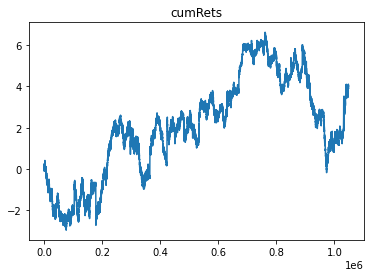

In [3]:
#load data e fa midprice/ritorni cum
lob_data=pd.read_csv('/Users/macri/Desktop/out_1.csv') #out_1 out_Nuovo
lob_data.reset_index(drop=True,inplace=True)
lob_data.drop(['index'], axis=1,inplace=True)
C= int(len(lob_data)*1)
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])#.plot()
m['r']=m['m'].diff()#calcola le differenze di midprice ogni 10 eventi ->differenze secondo il vettore h_K
m['rCum']=m['r'].cumsum()
of_data['r']=m['rCum']#*100
of_data.dropna(inplace=True)
of_data['r'].plot()
plt.title('cumRets')
plt.show()

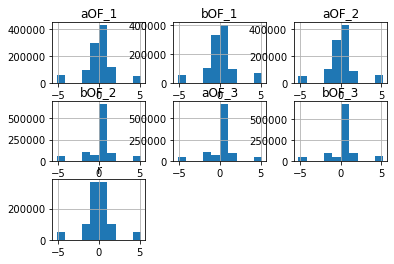

In [4]:
#normalizza e taglia al 0.005 e 99.995
x1=of_data['aOF_1']
x2=of_data['bOF_1']
x3=of_data['aOF_2']
x4=of_data['bOF_2']
x5=of_data['aOF_3']
x6=of_data['bOF_3']
x7=of_data['r'    ]
UPPERBOUND , LOWERBOUND =np.percentile(x1, [5,95])
UPPERBOUND1, LOWERBOUND1=np.percentile(x2, [5,95])
UPPERBOUND2, LOWERBOUND2=np.percentile(x3, [5,95])
UPPERBOUND3, LOWERBOUND3=np.percentile(x4, [5,95])
UPPERBOUND4, LOWERBOUND4=np.percentile(x5, [5,95])
UPPERBOUND5, LOWERBOUND5=np.percentile(x6, [5,95])
UPPERBOUND6, LOWERBOUND6=np.percentile(x7, [5,95])
x1Per=np.clip(x1,UPPERBOUND ,LOWERBOUND )
x2Per=np.clip(x2,UPPERBOUND1,LOWERBOUND1)
x3Per=np.clip(x3,UPPERBOUND2,LOWERBOUND2)
x4Per=np.clip(x4,UPPERBOUND3,LOWERBOUND3)
x5Per=np.clip(x5,UPPERBOUND4,LOWERBOUND4)
x6Per=np.clip(x6,UPPERBOUND5,LOWERBOUND5)
x7Per=np.clip(x7,UPPERBOUND6,LOWERBOUND6)


aOF_1_per= normalizer.fit_transform((x1Per.values.reshape(-1,1))).flatten().tolist()
bOF_1_per= normalizer.fit_transform((x2Per.values.reshape(-1,1))).flatten().tolist()
aOF_2_per= normalizer.fit_transform((x3Per.values.reshape(-1,1))).flatten().tolist()
bOF_2_per= normalizer.fit_transform((x4Per.values.reshape(-1,1))).flatten().tolist()
aOF_3_per= normalizer.fit_transform((x5Per.values.reshape(-1,1))).flatten().tolist()
bOF_3_per= normalizer.fit_transform((x6Per.values.reshape(-1,1))).flatten().tolist()
r_per    = normalizer.fit_transform((x7Per.values.reshape(-1,1))).flatten().tolist()

data = {'aOF_1': aOF_1_per,
        'bOF_1': bOF_1_per,
        'aOF_2': aOF_2_per,
        'bOF_2': bOF_2_per,
        'aOF_3': aOF_3_per,
        'bOF_3': bOF_3_per,
        'r'    : r_per    
        }

offlo=pd.DataFrame(data)
offlo.dropna(inplace=True)
offlo.hist()
plt.show()

In [5]:
#x = of_data[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']]
#y = of_data['r']
#norma=QuantileTransformer(output_distribution='normal')
#normal=QuantileTransformer(output_distribution='normal')
#scaledY = norma.fit_transform(y.values.reshape(-1,1))
#scaledX = normal.fit_transform(x)
#
#UPPERBOUND, LOWERBOUND = np.percentile(x, [5,95])
#xPer = np.clip(scaledX, UPPERBOUND, LOWERBOUND)
#yPer = np.clip(scaledY, UPPERBOUND, LOWERBOUND)
#
#
#pd.DataFrame(xPer).hist()
#pd.DataFrame(yPer).hist()

In [6]:
#fa dataset
y=of_data['r'].to_numpy()
idx=10000
r=np.empty((idx,10))
h=[ 22, 44, 89, 133, 178, 223, 267, 312, 356, 401]

for i in range(idx): #righe
    for ii,iii in zip(range(10),h): #colonne, steps
        r[i,ii]=y[i+iii]-y[i]
#potrebbe essere che devi normalizzare il vettore (n,10)

x_vec=of_data[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:1000000]
x=x_vec.to_numpy()
x_vecc=x.reshape(-1,100, 6, 1)

r.shape, x_vecc.shape

((10000, 10), (10000, 100, 6, 1))

In [7]:
#fa supervised dataset: train, val e test
l=len(x_vecc)
a=int(l*0.6)
b=int(l*0.39)
x_vecc_train=x_vecc[:a]
r_train     =r[:a]
x_vecc_val  =x_vecc[a:a+b]
r_val       =r[a:a+b]
x_vecc_test =x_vecc[a+b:a+b+1]
r_test      =r[a+b:a+b+1]
print(x_vecc_train.shape, r.shape)
print(x_vecc_val.shape,   r_val.shape)
print(x_vecc_test.shape,  r_test.shape)


(6000, 100, 6, 1) (10000, 10)
(3900, 100, 6, 1) (3900, 10)
(1, 100, 6, 1) (1, 10)


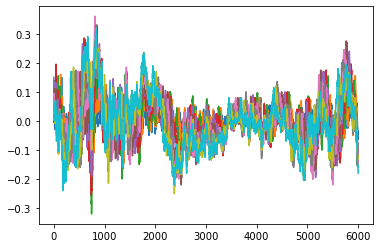

In [8]:
#check visivo se white noise
plt.plot(r_train)
plt.show()

In [9]:
#architettura della rete
def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    #  LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)
    # output layer
    out = Dense(10, activation='leaky_relu')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse')#, metrics=['accuracy']

    return model
  
deeplob = create_nn(100, 6,64)

deeplob.summary()
checkpoint_filepath = './model_tensorflow2/weights'


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [10]:
#early stopping: pazienza=3 e check val_loss
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [12]:
#fitta il modello
simple=deeplob.fit(x_vecc, r, validation_data=(x_vecc_val, r_val),  epochs=50, batch_size=256,callbacks=[callback])

Epoch 1/50
40/40 [==============================] - 9s 220ms/step - loss: 0.0401 - val_loss: 0.0369
Epoch 2/50
40/40 [==============================] - 9s 224ms/step - loss: 0.0331 - val_loss: 0.0315
Epoch 3/50
40/40 [==============================] - 9s 231ms/step - loss: 0.0288 - val_loss: 0.0279
Epoch 4/50
40/40 [==============================] - 9s 227ms/step - loss: 0.0257 - val_loss: 0.0257
Epoch 5/50
40/40 [==============================] - 9s 225ms/step - loss: 0.0237 - val_loss: 0.0234
Epoch 6/50
40/40 [==============================] - 9s 233ms/step - loss: 0.0217 - val_loss: 0.0212
Epoch 7/50
40/40 [==============================] - 9s 230ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 8/50
40/40 [==============================] - 9s 230ms/step - loss: 0.0184 - val_loss: 0.0186
Epoch 9/50
40/40 [==============================] - 9s 234ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 10/50
40/40 [==============================] - 11s 275ms/step - loss: 0.0157 - val_loss: 0.016

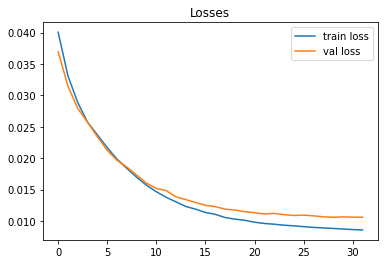

In [13]:
#plotta le loss
plt.plot(simple.history['loss'], label='train loss')
plt.plot(simple.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')
plt.show()

In [14]:
Ptrain= deeplob.predict(x_vecc_train)
Ptest = deeplob.predict(x_vecc_test)

1/1 [==============================] - 0s 16ms/step


In [44]:
y_pred_test =normalizer.inverse_transform(Ptest.reshape(-1,1))
y_true_test =normalizer.inverse_transform(r_test.reshape(-1,1))
y_pred_train=normalizer.inverse_transform(Ptrain.reshape(-1,1))
y_true_train=normalizer.inverse_transform(r_train.reshape(-1,1))

In [53]:
#MeanSquaredErrors ed R^2_{OS}
1-(mse(r_test[0],Ptest[0],squared=True)/mse(r_train,Ptrain,squared=True))

0.15908519896077256

In [94]:
def calcola_mse(y_true,y_pred):
    mse=(y_true-y_pred)**2/y_true**2
    return mse

In [95]:
num=calcola_mse(r_test,Ptest)
den=calcola_mse(r_train,Ptrain)
R2=1-num/np.mean(den)
R2

C:\Users\macri\AppData\Local\Temp\ipykernel_18068\2316489128.py:2: RuntimeWarning: divide by zero encountered in true_divide
  mse=(y_true-y_pred)**2/y_true**2


array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [99]:
a=1-calcola_mse(r_test,Ptest)

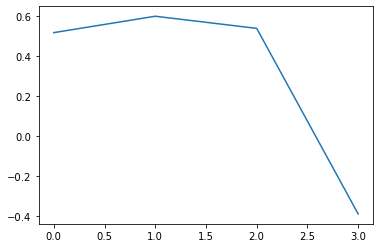

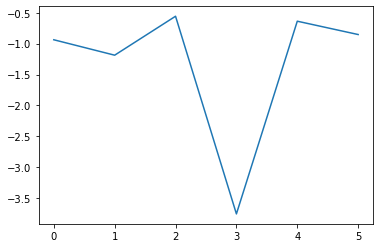

In [104]:
plt.plot(a[0][:4])
plt.show()
plt.plot(a[0][4:])
plt.show()

In [23]:
from sklearn.metrics import r2_score as r2
r2(r_test[0],Ptest[0])/r2(r_train,Ptrain)